## Language Model Training Pipeline


In [14]:
import json
import torch
import evaluate
import transformers
import numpy as np
import pandas as pd
from torch import nn
from torch_lr_finder import LRFinder
from pathlib import Path
from tqdm.notebook import tqdm
from datasets import Dataset
from tokenizers import Tokenizer
from tokenizers.normalizers import Sequence, Lowercase, NFD, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.decoders import BPEDecoder
from transformers import (
    AutoConfig,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    RobertaConfig,
)
from matplotlib import pyplot as plt
import importlib
from sklearn.metrics import roc_curve, auc

In [15]:
torch.cuda.empty_cache()

## Configuration files


In [16]:
data_path = Path("filler")
seed = 42

# Tokenizer
tokenizer_path = data_path / "tokenizer/tokenizer.json"

# Language Model Pretraining
pretrained_output_model_path = data_path / "pretrain_lm"

# Classifier Finetuning
classifier_output_model_path = data_path / "finetune_lm"
batch_size = 32
epochs = 8
learning_rate = 5e-5

## Prepare data


In [17]:
# Prepare data
train_df = pd.read_csv(data_path / "finetune_fragment_train.csv")
val_df = pd.read_csv(data_path / "finetune_fragment_valid.csv")
train_ds = Dataset.from_dict(train_df)
val_ds = Dataset.from_dict(val_df)

In [18]:
# Set random seed
np.random.seed(seed)
torch.manual_seed(seed)

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path.parent)
config = AutoConfig.from_pretrained(pretrained_output_model_path)
config.num_labels = len(set(train_df["label"]))

# Get pretrained model
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_output_model_path, config=config
)
tokenizer.pad_token = "<pad>"
config.pad_token_id = tokenizer.pad_token_id
model.pad_token_id = tokenizer.pad_token_id
tokenizer.model_max_length = config.n_positions

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at filler/pretrain_lm were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at filler/pretrain_lm and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

In [19]:
def tokenizer_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


# Tokenize and convert labels to ids
train_ds = train_ds.map(tokenizer_function, batched=True)
val_ds = val_ds.map(tokenizer_function, batched=True)

Map:   0%|          | 0/3378 [00:00<?, ? examples/s]

Map:   0%|          | 0/2220 [00:00<?, ? examples/s]

In [20]:
ds_list = [train_ds, val_ds]
ds_list = [ds.remove_columns(["text"]) for ds in ds_list]
ds_list = [ds.rename_column("label", "labels") for ds in ds_list]
[ds.set_format("torch") for ds in ds_list]
train_dl = torch.utils.data.DataLoader(ds_list[0], shuffle=True, batch_size=batch_size)
val_dl = torch.utils.data.DataLoader(ds_list[1], batch_size=batch_size)
torch.save(train_dl, data_path / "train_data_loader.pkl")
torch.save(val_dl, data_path / "val_data_loader.pkl")

In [21]:
# Freeze all layers except the last one
for name, param in model.named_parameters():
    param.requires_grad = False
model.score.weight.requires_grad = True

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(30001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = epochs
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = transformers.get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

## Finetune classifier


In [11]:
progress_bar = tqdm(range(num_training_steps))
metric = evaluate.load("accuracy")
log_history = []
classifier_output_model_path.mkdir(parents=True, exist_ok=True)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        train_loss += loss.item()
    train_loss /= len(train_dl)

    model.eval()
    val_loss = 0
    for batch in val_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits

        # Apply softmax function along the last dimension
        softmax_logits = torch.softmax(logits, dim=-1)

        # Get the predicted class probabilities
        class_probs = softmax_logits[:, 1]  # class 1 is the filler class

        # Round the probabilities to get the predicted class
        predictions = (class_probs > 0.5).float()

        metric.add_batch(predictions=predictions, references=batch["labels"])
        val_loss += outputs.loss.item()
    val_loss /= len(val_dl)

    acc = metric.compute()
    print(
        f"Epoch: {epoch}, TrainLoss: {train_loss:.3f}, ValLoss: {val_loss:.3f}, Accuracy: {acc['accuracy']:.3f}"
    )
    log_history.append(
        {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "accuracy": acc["accuracy"],
        }
    )
    model.save_pretrained(classifier_output_model_path / f"epoch_{epoch}")

with open(classifier_output_model_path / "log_history.json", "w") as fout:
    json.dump(log_history, fout)

  0%|          | 0/848 [00:00<?, ?it/s]

Epoch: 0, TrainLoss: 0.568, ValLoss: 0.406, Accuracy: 0.860
Epoch: 1, TrainLoss: 0.334, ValLoss: 0.273, Accuracy: 0.925
Epoch: 2, TrainLoss: 0.245, ValLoss: 0.215, Accuracy: 0.939
Epoch: 3, TrainLoss: 0.201, ValLoss: 0.185, Accuracy: 0.948
Epoch: 4, TrainLoss: 0.180, ValLoss: 0.168, Accuracy: 0.952
Epoch: 5, TrainLoss: 0.163, ValLoss: 0.158, Accuracy: 0.955
Epoch: 6, TrainLoss: 0.156, ValLoss: 0.152, Accuracy: 0.955
Epoch: 7, TrainLoss: 0.153, ValLoss: 0.151, Accuracy: 0.955


## Visualize training curves


In [6]:
with open(classifier_output_model_path / "log_history.json", "r") as f:
    log = json.load(f)

epochs = [metric["epoch"] for metric in log]
train_loss = [metric["train_loss"] for metric in log]
val_loss = [metric["val_loss"] for metric in log]
accuracy = [metric["accuracy"] for metric in log]

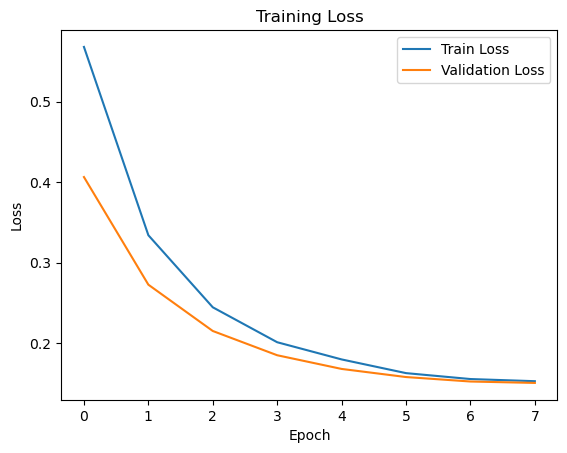

In [10]:
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

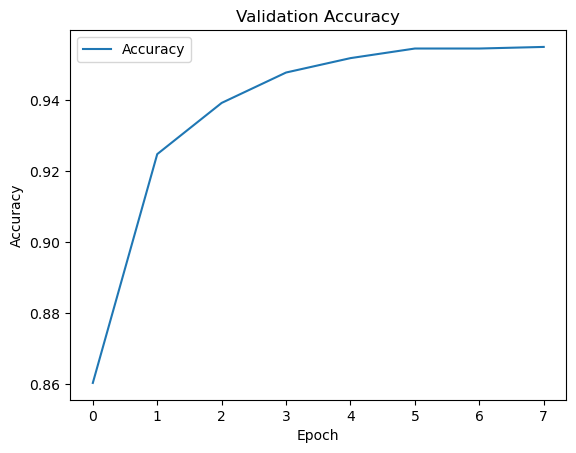

In [11]:
plt.plot(epochs, accuracy, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

In [9]:
print(f"Validation accuracy on fragments = {accuracy[-1]}")

Validation accuracy on fragments = 0.954954954954955


## Create ROC curve


In [24]:
model = AutoModelForSequenceClassification.from_pretrained(
    classifier_output_model_path / f"epoch_7"
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
metric = evaluate.load("accuracy")

In [25]:
model.eval()
labels = []
probabilities = []
predictions = []

for batch in val_dl:
    batch = {k: v.to(device) for k, v in batch.items()}
    labels.append(batch["labels"])

    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    probability = torch.softmax(logits, dim=1)

    probabilities.append(probability)
    prediction = torch.argmax(logits, dim=-1)
    predictions.append(prediction)

    metric.add_batch(predictions=prediction, references=batch["labels"])

accuracy = metric.compute()["accuracy"]
print(f"Fragement accuracy: {accuracy}")

Fragement accuracy: 0.954954954954955


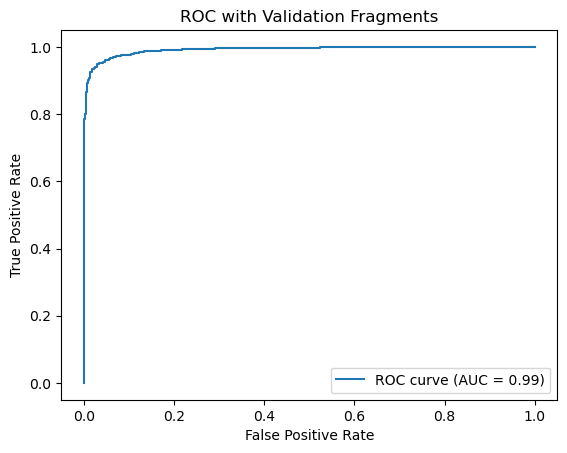

In [27]:
prob = [float(p) for tensor in probabilities for f, p in tensor]
lab = [float(c) for tensor in labels for c in tensor]
fpr, tpr, thresholds = roc_curve(y_true=lab, y_score=prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(roc_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC with Validation Fragments")
plt.legend()
plt.show()